In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [5]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial
from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import defaultdict, deque, namedtuple
import os
import argparse
import atari_py
import torch
import torch.nn.functional as F

from agent import Agent
from env import make_env
from masker import ALL_MASKERS

In [6]:
np.set_printoptions(precision=5)

In [7]:
api = wandb.Api()

In [8]:
CHECKPOINT_SCRATCH_FOLDER = '/scratch/gd1279'

if not os.path.exists(CHECKPOINT_SCRATCH_FOLDER):
    os.mkdir(CHECKPOINT_SCRATCH_FOLDER)

# Recreate the args 

In [9]:
# Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--save-evaluation-gifs', action='store_true', help='Save GIFs of evaluation episodes')
parser.add_argument('--evaluation-gif-folder', default=None, help='Folder to save evaluation GIFs in')
parser.add_argument('--save-evaluation-states', action='store_true', help='Save the states of evaluation episodes')
parser.add_argument('--evaluation-state-folder', default=None, help='Folder to save evaluation state in')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)
parser.add_argument('--memory-save-interval', type=int, default=None, help='How often to save the memory, defaults to the evaluation interval')
parser.add_argument('--use-native-pickle-serialization', action='store_true', help='Use native pickle saving rather than torch.save()')

# Arguments for the augmented representations
parser.add_argument('--add-masks', action='store_true', help='Add masks for each semantic object types')
parser.add_argument('--maskers', default=None, help='Select specific maskers to use')
parser.add_argument('--use-numpy-masker', action='store_true', help='Use the previous, much slower numpy-based masker')
parser.add_argument('--omit-pixels', action='store_true', help='Omit the raw pixels from the environment')

# Arguments to give it a soft time cap that will help it not fail
parser.add_argument('--soft-time-cap', help='Format: <DD>:HH:MM, stop after some soft cap such that the saving the memory does not fail')

# Debugging-related arguments
parser.add_argument('--debug-heap', action='store_true')
parser.add_argument('--heap-interval', default=1e4)
parser.add_argument('--heap-debug-file', default=None)


_StoreAction(option_strings=['--heap-debug-file'], dest='heap_debug_file', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

# Load a run and its model

In [10]:
def download_checkpoint(run, step=None):
    files = run.files()
    if step is None:
        step = max([int(f.name[f.name.rfind('-') + 1:f.name.rfind('.')]) 
                    for f in files 
                    if f.name.endswith('.pth')])
        
    sample_name = [f.name for f in files if f.name.endswith('.pth')][0]
    checkpoint_name = sample_name[:sample_name.rfind('-')]
    checkpoint_file = f'{checkpoint_name}-{step}.pth'
    run.file(checkpoint_file).download(replace=True, root=CHECKPOINT_SCRATCH_FOLDER)
    return os.path.join(CHECKPOINT_SCRATCH_FOLDER, checkpoint_file)


def setup_args(run):
    args = parser.parse_args([])
    config = run.config
    
    for key in config:
        if key in args:
            args.__setattr__(key, config[key])
            
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if torch.cuda.is_available() and not args.disable_cuda:
        args.device = torch.device('cuda')
        # torch.cuda.manual_seed(np.random.randint(1, 10000))
        torch.cuda.manual_seed(args.seed)
        torch.backends.cudnn.enabled = args.enable_cudnn
    else:
        args.device = torch.device('cpu')
            
    return args


LOADED_MODEL_CACHE = {}


def load_model_from_run(run, cache=LOADED_MODEL_CACHE):
    if run not in cache:
        checkpoint_path = download_checkpoint(run)
        args = setup_args(run)
        args.model = checkpoint_path

        env = make_env(args)
        dqn = Agent(args, env)
        cache[run] = dqn, env
        
    return cache[run]

# Gameplan

1. Load the data, with the number of different table formats it could appear for.
2. Bar plots jointly of each mode alone.

In [257]:
POTENTIAL_KEYS = ('Zero Mask Evaluation Results for indices [[]]',
                 'Zero Mask Evaluation Results for indices',
                 'Zero Mask Evaluation Results')

DEFAULT_MERGE_COLUMN = 'Zero Indices'

def load_single_run_data(run, potential_keys=POTENTIAL_KEYS, merge_column=DEFAULT_MERGE_COLUMN):
    history = run.history()
    dataframes = []
    for key in potential_keys:
        if key in history:
            table_data = history[key][history[key].last_valid_index()]
            df = pd.DataFrame(data=table_data['data'], columns=table_data['columns'])
            if type(df[merge_column][0]) == list:
                df[merge_column] = df[merge_column].apply(tuple)
            dataframes.append(df)
    
    dataframes = sorted(dataframes, key=lambda x: x.shape[0], reverse=True)
    joined_df = pd.concat(dataframes)
    joined_df.drop_duplicates(subset=[merge_column], inplace=True)
    joined_df.sort_values(merge_column, inplace=True)
    return joined_df
            

DEFAULT_COLUMN_SETS = (
    [f'Reward #{i + 1}' for i in range(10)],
    [f'Steps #{i + 1}' for i in range(10)]
)
    
    
def load_multiple_run_data(runs, column_sets=DEFAULT_COLUMN_SETS, new_column_names=None):
    if new_column_names is None:
        new_column_names = ['None'] + list(range(8))
        
    dataframes = [load_single_run_data(run) for run in runs]
    output_dfs = []
    for column_set in column_sets:
        subset_dataframes = [df[column_set].T for df in dataframes]
        for subset_df in subset_dataframes:
            subset_df.columns = new_column_names

        joined_df = pd.concat(subset_dataframes)

        if np.any(joined_df.isna().sum()):
            print(f'NaNs in column set {column_set}')

        output_dfs.append(joined_df)
        
    return output_dfs


DEFAULT_MASK_NAMES = (
    'None',
    'player',
    'bad_animal',
    'land',
    'bear',
    'unvisited_floe',
    'visited_floe',
    'good_animal',
    'igloo'
)


def create_joint_box_plots(rewards, steps, ax=None, title=None, step_color='blue', fontdict=dict(fontsize=16),
                           mask_names=DEFAULT_MASK_NAMES):
    if ax is None:
        plt.figure(figsize=(12, 8))
        reward_ax = plt.gca()
    
    else:
        reward_ax = ax
    
    reward_positions = np.arange(rewards.shape[1]) * 2
    reward_ax.boxplot(rewards.T, positions=reward_positions)
    dashed_line_positions = (reward_positions + 1.5)[:-1]
    reward_ax.vlines(dashed_line_positions, *reward_ax.get_ylim(),
                     colors='gray', linestyles='dashed')
    
    reward_ax.set_xlabel('Zero\'d Out Channel', fontdict=fontdict)
    reward_ax.set_ylabel('Reward', fontdict=fontdict)
    
    steps_ax = plt.twinx(ax=reward_ax)
    steps_positions = 1 + np.arange(rewards.shape[1]) * 2
    steps_ax.boxplot(steps.T, positions=steps_positions, showfliers=False, boxprops=dict(color=step_color),
                     whiskerprops=dict(color=step_color))
    
    steps_ylabel_fontdict = dict(color=step_color, fontsize=fontdict['fontsize'])
    steps_ax.set_ylabel('Steps', fontdict=steps_ylabel_fontdict)
    steps_ax.tick_params(axis='y', colors=step_color)
    
    xtick_positions = np.stack([reward_positions, steps_positions]).mean(0)
    if mask_names is None:
        mask_names = rewards.columns
    plt.xticks(xtick_positions, mask_names)
    
    if title is not None:
        reward_ax.set_title(title, fontdict=fontdict)
        
    if ax is None:
        plt.show()
        
    return reward_ax, steps_ax


In [203]:
masks_and_pixels_runs = api.runs('augmented-frostbite/masks-and-pixels-fixed-resume/runs')
masks_and_pixels_rewards, masks_and_pixels_steps = load_multiple_run_data(masks_and_pixels_runs)

masks_and_pixels_rep_runs = api.runs('augmented-frostbite/masks-and-pixels-replication/runs')
masks_and_pixels_rep_rewards, masks_and_pixels_rep_steps = load_multiple_run_data(masks_and_pixels_rep_runs)

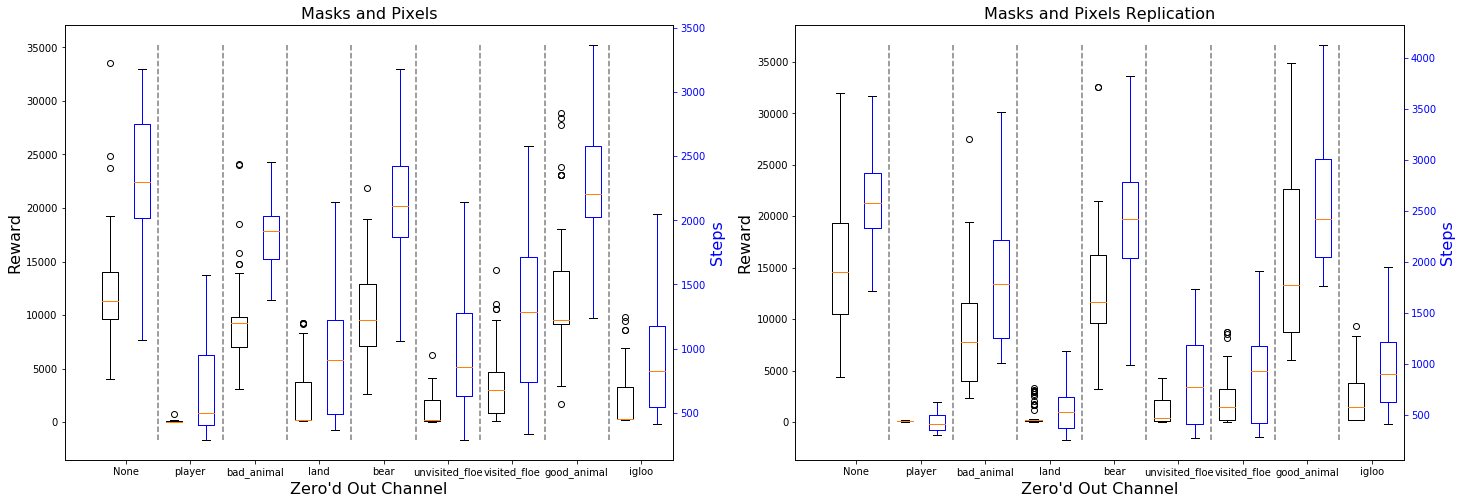

In [242]:
plt.figure(figsize=(24, 8))

m_p_ax = plt.subplot(1, 2, 1)
create_joint_box_plots(masks_and_pixels_rewards, masks_and_pixels_steps, ax=m_p_ax, title='Masks and Pixels')

m_p_rep_ax = plt.subplot(1, 2, 2)
create_joint_box_plots(masks_and_pixels_rep_rewards, masks_and_pixels_rep_steps, ax=m_p_rep_ax, title='Masks and Pixels Replication')

plt.show()

In [238]:
masks_only_runs = api.runs('augmented-frostbite/masks-only/runs')
masks_only_rewards, masks_only_steps = load_multiple_run_data(masks_only_runs)

masks_only_rep_runs = api.runs('augmented-frostbite/masks-only-replication/runs')
masks_only_rep_rewards, masks_only_rep_steps = load_multiple_run_data(masks_only_rep_runs)

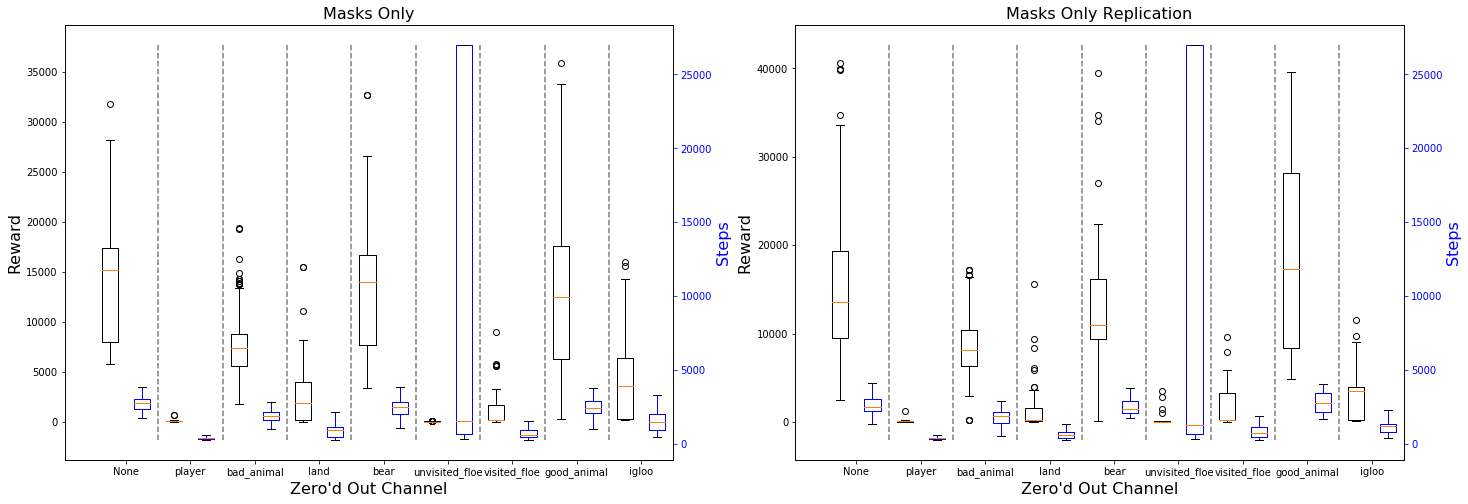

In [243]:
plt.figure(figsize=(24, 8))

m_o_ax = plt.subplot(1, 2, 1)
create_joint_box_plots(masks_only_rewards, masks_only_steps, ax=m_o_ax, title='Masks Only')

m_o_rep_ax = plt.subplot(1, 2, 2)
create_joint_box_plots(masks_only_rep_rewards, masks_only_rep_steps, ax=m_o_rep_ax, title='Masks Only Replication')

plt.show()

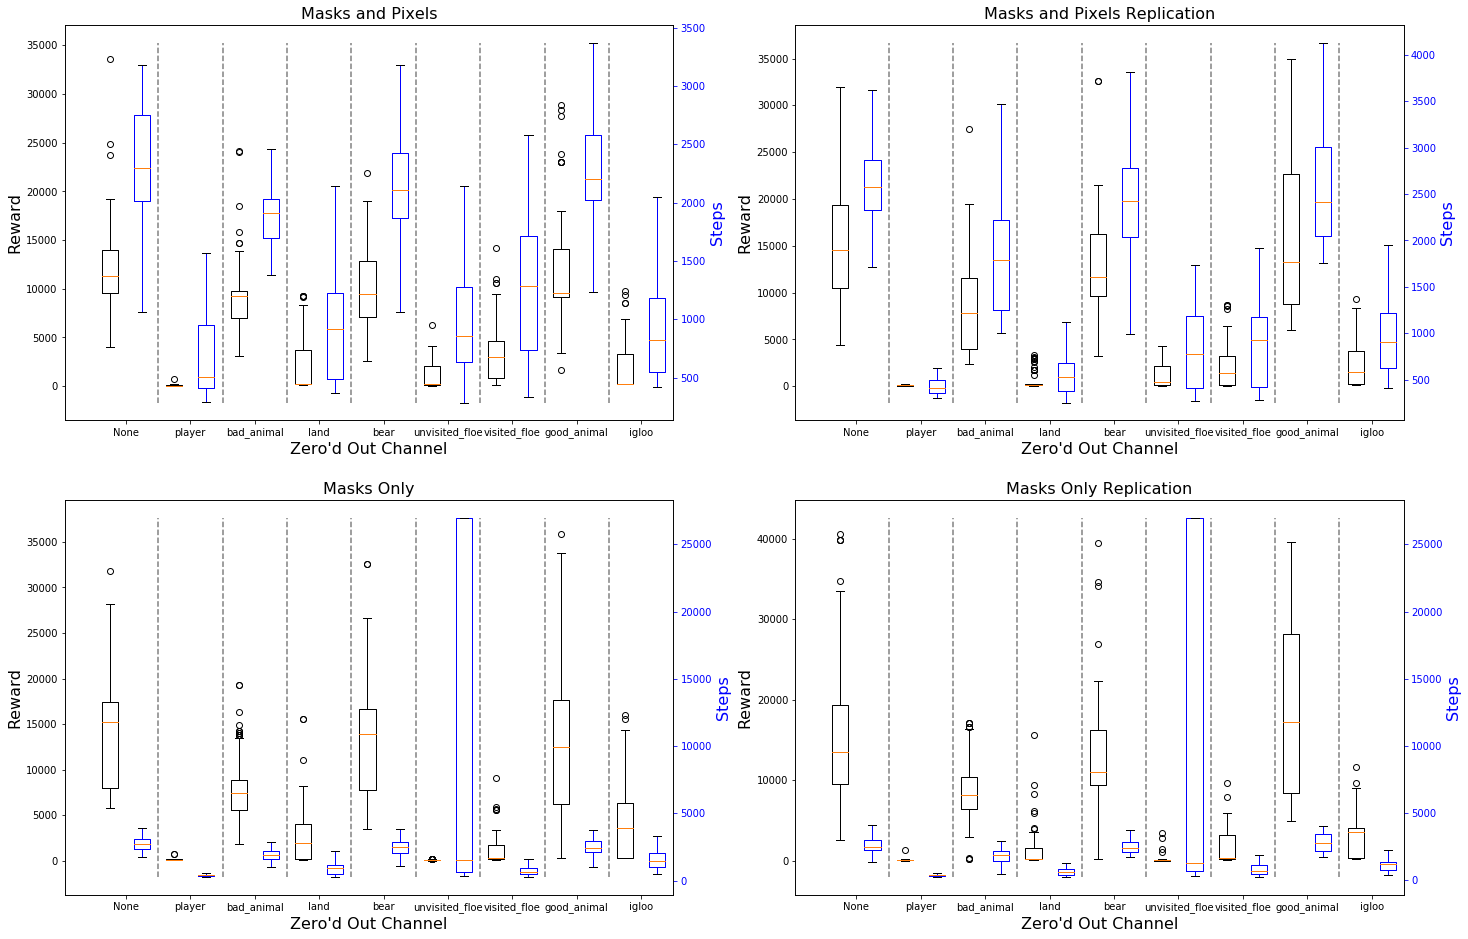

In [244]:
plt.figure(figsize=(24, 16))

m_p_ax = plt.subplot(2, 2, 1)
create_joint_box_plots(masks_and_pixels_rewards, masks_and_pixels_steps, ax=m_p_ax, title='Masks and Pixels')

m_p_rep_ax = plt.subplot(2, 2, 2)
create_joint_box_plots(masks_and_pixels_rep_rewards, masks_and_pixels_rep_steps, ax=m_p_rep_ax, title='Masks and Pixels Replication')

m_o_ax = plt.subplot(2, 2, 3)
create_joint_box_plots(masks_only_rewards, masks_only_steps, ax=m_o_ax, title='Masks Only')

m_o_rep_ax = plt.subplot(2, 2, 4)
create_joint_box_plots(masks_only_rep_rewards, masks_only_rep_steps, ax=m_o_rep_ax, title='Masks Only Replication')

plt.show()

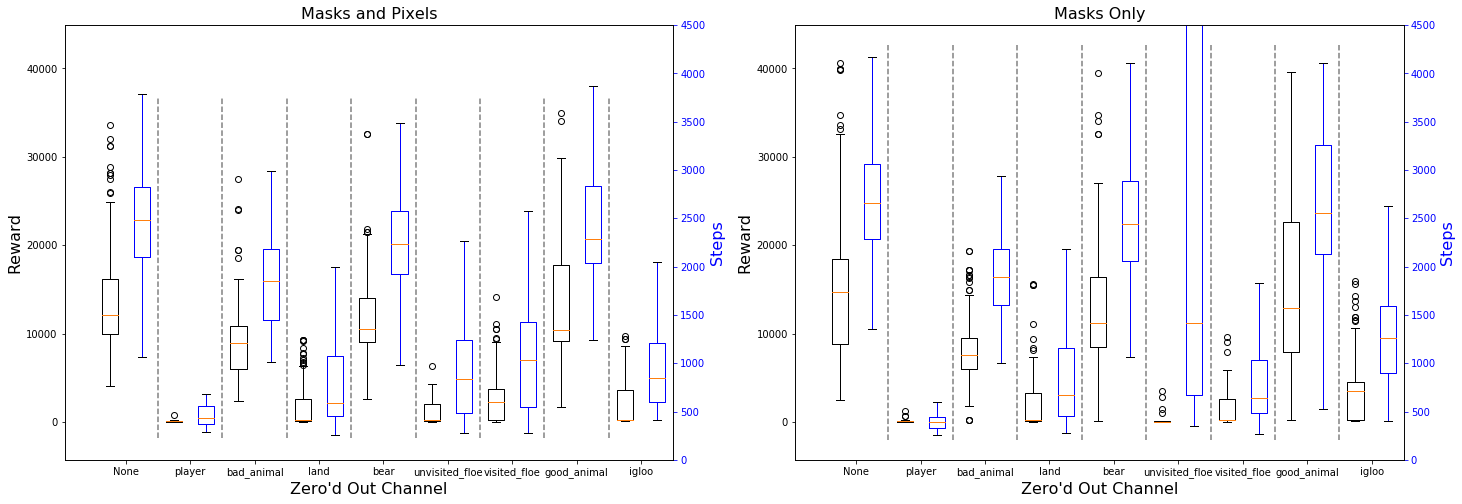

In [262]:
plt.figure(figsize=(24, 8))

m_p_ax = plt.subplot(1, 2, 1)
m_p_reward_ax, m_p_steps_ax = create_joint_box_plots(pd.concat([masks_and_pixels_rewards, masks_and_pixels_rep_rewards]), 
                       pd.concat([masks_and_pixels_steps, masks_and_pixels_rep_steps]), ax=m_p_ax, title='Masks and Pixels')

m_o_ax = plt.subplot(1, 2, 2)
m_o_reward_ax, m_o_steps_ax = create_joint_box_plots(pd.concat([masks_only_rewards, masks_only_rep_rewards]), 
                       pd.concat([masks_only_steps, masks_only_rep_steps]), ax=m_o_ax, title='Masks Only')

m_p_reward_ax.set_ylim(m_o_reward_ax.get_ylim())
m_p_steps_ax.set_ylim((0, 4500))
m_o_steps_ax.set_ylim((0, 4500))

plt.show()

In [266]:
rewards = pd.concat([masks_only_rewards, masks_only_rep_rewards])
steps = pd.concat([masks_only_steps, masks_only_rep_steps])

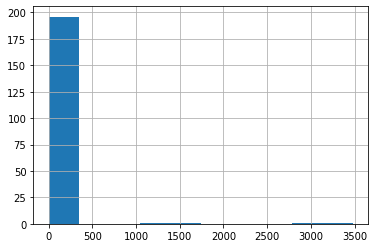

In [267]:
rewards[4].hist()

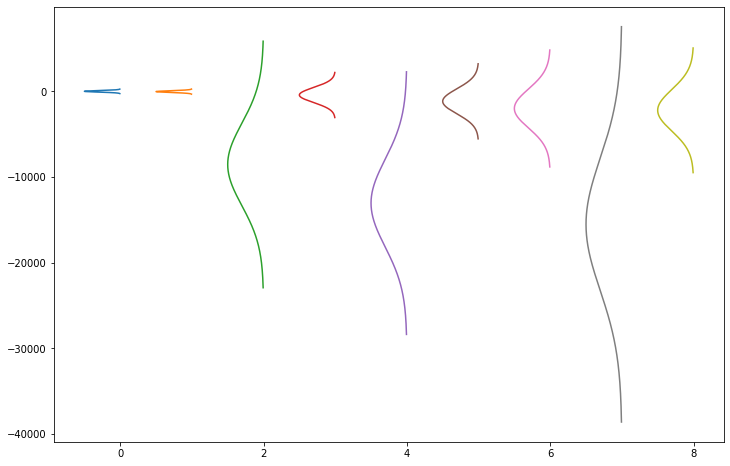

In [253]:
def draw_gaussian(support, sd=1.0, height=1.0, xpos=0.0, ypos=0.0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    gaussian = np.exp((-support ** 2.0) / (2 * sd ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= height
    return ax.plot(gaussian + xpos, support + ypos, **kwargs)


def plot_vertical_difference_gaussians(rewards, steps, ax=None, n_samples=1000, height=0.5, yscale='linear'):
    if ax is None:
        plt.figure(figsize=(12, 8))
        reward_ax = plt.gca()
    
    else:
        reward_ax = ax
        
    reward_ax.set_yscale(yscale)

    reward_means = rewards.mean()
    reward_stds = rewards.std()
    
    baseline_mean = reward_means[0]
    baseline_std = reward_stds[0]
    
    baseline_support = np.linspace(-3 * baseline_std, 3 * baseline_std, n_samples)
    draw_gaussian(baseline_support, baseline_std, height * -1, ax=reward_ax)
    
    for i, (mean, std) in enumerate(zip(masks_and_pixels_rep_rewards.mean()[1:], masks_and_pixels_rep_rewards.std()[1:])):
        mean -= baseline_mean
        std = ((std ** 2) + (baseline_std ** 2)) ** 0.5
        
        support = np.linspace(-3 * std, 3 * std, n_samples)
        draw_gaussian(support, std, height * -1, xpos=i + 1, ypos=-1 * mean, ax=reward_ax)
    
    if ax is None:
        plt.show()

        
plot_vertical_difference_gaussians(masks_and_pixels_rewards, masks_and_pixels_steps)

In [248]:
for x,y in zip(masks_and_pixels_rep_rewards.mean()[1:], masks_and_pixels_rep_rewards.std()[1:]):
    print(x, y)

118.2 46.174460560799275
8623.6 4794.946523332267
516.4 871.8510668848669
13134.1 5108.1648041803255
1251.3 1457.1576421030747
2088.5 2272.8584659104063
15613.8 7690.517811046279
2301.1 2423.095063522825


In [150]:
run = api.run('augmented-frostbite/masks-and-pixels-fixed-resume/runs/nyvgd8f8')

In [178]:
df = load_single_run_data(run)

In [154]:
history = run.history()
dataframes = []
for key in POTENTIAL_KEYS:
    if key in history:
        table_data = history[key][history[key].first_valid_index()]
        dataframes.append(pd.DataFrame(data=table_data['data'], columns=table_data['columns']))


In [161]:
for d in dataframes:
    d['Zero Indices'] = d['Zero Indices'].apply(tuple)

In [184]:
df.sort_values('Zero Indices', inplace=True)

,Zero Indices,Reward #1,Reward #2,Reward #3,Reward #4,Reward #5,Reward #6,Reward #7,Reward #8,Reward #9,...,Steps #5,Steps #6,Steps #7,Steps #8,Steps #9,Steps #10,Reward Mean,Reward Std,Step Mean,Step Std
0,(),10530,10750,9940,10810,10810,10940,9940,10610,11450,...,2331,2543,2144,2229,2659,2486,10780,593.076724,2333.5,168.109042
1,"(0,)",110,130,770,150,110,210,180,180,180,...,662,1080,411,412,414,1080,223,185.636742,745.9,272.032149
2,"(1,)",15800,9630,4780,3070,9630,11450,9630,4780,9900,...,1915,2647,1912,1381,1993,2457,8976,3597.043786,1947.6,553.224584
3,"(2,)",240,210,210,190,240,180,210,180,210,...,459,451,546,449,448,445,208,19.899749,459.8,29.226016
4,"(3,)",9880,9880,9880,14290,2590,9680,13910,13910,6910,...,1109,1963,2628,2625,1614,1950,10081,3369.434522,2028.2,450.657031
5,"(4,)",150,150,160,170,150,860,3670,1190,150,...,392,712,1278,767,398,716,751,1042.530095,614.0,262.801446
6,"(5,)",3640,1490,5370,290,5230,1490,260,5370,290,...,1538,884,601,1794,668,1790,2880,2210.095021,1166.1,480.493382
7,"(6,)",8320,8060,9120,9460,9460,8060,9460,9020,14010,...,2174,1993,2125,2100,2544,2084,9361,1637.244331,2209.1,199.920709
8,"(7,)",3590,4080,4080,4390,280,4390,4750,4680,3350,...,610,1533,1430,1513,1449,612,3387,1607.843587,1291.9,353.181667


In [167]:
df.drop_duplicates(subset=('Zero Indices',))

,Zero Indices,Reward #1,Reward #2,Reward #3,Reward #4,Reward #5,Reward #6,Reward #7,Reward #8,Reward #9,...,Steps #5,Steps #6,Steps #7,Steps #8,Steps #9,Steps #10,Reward Mean,Reward Std,Step Mean,Step Std
0,(),9710,10520,9940,9940,13230,13670,14130,9940,10880,...,2307,2482,2453,2146,2260,2150,11190,1671.556161,2222.9,141.069097
1,"(0,)",110,130,770,150,110,210,180,180,180,...,662,1080,411,412,414,1080,223,185.636742,745.9,272.032149
2,"(1,)",15800,9630,4780,3070,9630,11450,9630,4780,9900,...,1915,2647,1912,1381,1993,2457,8976,3597.043786,1947.6,553.224584
3,"(2,)",240,210,210,190,240,180,210,180,210,...,459,451,546,449,448,445,208,19.899749,459.8,29.226016
4,"(3,)",9880,9880,9880,14290,2590,9680,13910,13910,6910,...,1109,1963,2628,2625,1614,1950,10081,3369.434522,2028.2,450.657031
5,"(4,)",150,150,160,170,150,860,3670,1190,150,...,392,712,1278,767,398,716,751,1042.530095,614.0,262.801446
6,"(5,)",3640,1490,5370,290,5230,1490,260,5370,290,...,1538,884,601,1794,668,1790,2880,2210.095021,1166.1,480.493382
7,"(6,)",8320,8060,9120,9460,9460,8060,9460,9020,14010,...,2174,1993,2125,2100,2544,2084,9361,1637.244331,2209.1,199.920709
8,"(7,)",3590,4080,4080,4390,280,4390,4750,4680,3350,...,610,1533,1430,1513,1449,612,3387,1607.843587,1291.9,353.181667


In [162]:
pd.merge(dataframes[1], dataframes[0], on='Zero Indices')

,Zero Indices,Reward #1_x,Reward #2_x,Reward #3_x,Reward #4_x,Reward #5_x,Reward #6_x,Reward #7_x,Reward #8_x,Reward #9_x,...,Steps #5_y,Steps #6_y,Steps #7_y,Steps #8_y,Steps #9_y,Steps #10_y,Reward Mean_y,Reward Std_y,Step Mean_y,Step Std_y
0,(),10530,10750,9940,10810,10810,10940,9940,10610,11450,...,2307,2482,2453,2146,2260,2150,11190,1671.556161,2222.9,141.069097


In [14]:
h = run.history()

In [34]:
[key in h for key in POTENTIAL_KEYS]

[True, False, True]

In [26]:
h.columns

Index(['gradients/fc_z_a.bias_mu', 'gradients/convs.2.weight',
       'gradients/fc_h_a.bias_sigma', 'gradients/fc_h_v.bias_sigma',
       'gradients/fc_h_v.bias_mu', 'gradients/convs.4.bias',
       'gradients/fc_z_v.weight_sigma', 'gradients/fc_h_a.weight_mu',
       'gradients/fc_h_a.weight_sigma', 'gradients/fc_z_a.weight_mu',
       'gradients/convs.0.weight', 'gradients/convs.4.weight',
       'gradients/fc_z_v.bias_sigma', 'gradients/fc_h_v.weight_sigma',
       'gradients/fc_z_a.weight_sigma', 'gradients/convs.2.bias',
       'gradients/fc_h_v.weight_mu', 'gradients/fc_z_a.bias_sigma',
       'gradients/fc_z_v.bias_mu', 'gradients/fc_z_v.weight_mu',
       'gradients/convs.0.bias', 'gradients/fc_h_a.bias_mu', '_step',
       'Q_values', 'rewards', '_runtime', 'reward_mean', 'Q_value_std',
       'Q_value_mean', 'steps', 'reward_std', '_timestamp', 'human_hours',
       'Zero Mask Evaluation Results',
       'Zero Mask Evaluation Results for indices [[]]'],
      dtype='object')

In [20]:
td = h['Zero Mask Evaluation Results'][h['Zero Mask Evaluation Results'].first_valid_index()]
td.keys()

dict_keys(['data', '_type', 'columns'])

In [22]:
t = wandb.Table(td['columns'], td['data'])


In [30]:
df1 = pd.DataFrame(data=td['data'], columns=td['columns'])
df1

,Zero Indices,Reward #1,Reward #2,Reward #3,Reward #4,Reward #5,Reward #6,Reward #7,Reward #8,Reward #9,...,Steps #5,Steps #6,Steps #7,Steps #8,Steps #9,Steps #10,Reward Mean,Reward Std,Step Mean,Step Std
0,[0],180,180,70,70,70,70,110,180,70,...,322,330,414,562,318,561,118,51.923020,426.8,112.154180
1,[1],4480,7510,16230,7990,7990,16230,3100,14750,10900,...,2184,2709,1242,2480,2180,2484,10393,4630.086500,2168.9,449.181801
2,[2],1170,1720,1720,2890,3030,3030,3140,2890,1720,...,1071,1067,1056,1014,759,755,2303,713.443060,903.6,142.558199
3,[3],14290,10900,11720,11720,20480,10900,15850,14820,14820,...,2937,2191,2536,2598,2602,1841,13545,3013.152004,2432.3,281.775105
4,[4],3690,3890,3890,1250,2210,2770,2730,1240,3920,...,1077,1348,1413,882,1312,1058,2780,997.837662,1155.8,166.455279
5,[5],3720,3720,3500,3720,260,5890,260,5890,280,...,747,1644,746,1640,749,1915,3578,2612.924798,1292.0,398.158511
6,[6],9600,9110,9230,9430,19670,9430,19670,19000,19670,...,2889,2176,2887,2869,2883,2883,14448,5092.969271,2492.5,400.537202
7,[7],5860,2250,2980,5860,2980,5860,2250,4390,5860,...,1036,1663,969,1260,1661,1665,4415,1547.050419,1358.4,313.976496


In [31]:
td2 = h['Zero Mask Evaluation Results for indices [[]]'][h['Zero Mask Evaluation Results for indices [[]]'].first_valid_index()]
df2 = pd.DataFrame(data=td2['data'], columns=td2['columns'])
df2

,Zero Indices,Reward #1,Reward #2,Reward #3,Reward #4,Reward #5,Reward #6,Reward #7,Reward #8,Reward #9,...,Steps #5,Steps #6,Steps #7,Steps #8,Steps #9,Steps #10,Reward Mean,Reward Std,Step Mean,Step Std
0,[],20640,7100,7100,19590,16210,9620,16210,7260,8050,...,2860,1936,2856,1857,1916,2855,12799,5203.849441,2374.7,563.544861


In [38]:
df = pd.concat([df2, df1])
df

,Zero Indices,Reward #1,Reward #2,Reward #3,Reward #4,Reward #5,Reward #6,Reward #7,Reward #8,Reward #9,...,Steps #5,Steps #6,Steps #7,Steps #8,Steps #9,Steps #10,Reward Mean,Reward Std,Step Mean,Step Std
0,[],20640,7100,7100,19590,16210,9620,16210,7260,8050,...,2860,1936,2856,1857,1916,2855,12799,5203.849441,2374.7,563.544861
0,[0],180,180,70,70,70,70,110,180,70,...,322,330,414,562,318,561,118,51.923020,426.8,112.154180
1,[1],4480,7510,16230,7990,7990,16230,3100,14750,10900,...,2184,2709,1242,2480,2180,2484,10393,4630.086500,2168.9,449.181801
2,[2],1170,1720,1720,2890,3030,3030,3140,2890,1720,...,1071,1067,1056,1014,759,755,2303,713.443060,903.6,142.558199
3,[3],14290,10900,11720,11720,20480,10900,15850,14820,14820,...,2937,2191,2536,2598,2602,1841,13545,3013.152004,2432.3,281.775105
4,[4],3690,3890,3890,1250,2210,2770,2730,1240,3920,...,1077,1348,1413,882,1312,1058,2780,997.837662,1155.8,166.455279
5,[5],3720,3720,3500,3720,260,5890,260,5890,280,...,747,1644,746,1640,749,1915,3578,2612.924798,1292.0,398.158511
6,[6],9600,9110,9230,9430,19670,9430,19670,19000,19670,...,2889,2176,2887,2869,2883,2883,14448,5092.969271,2492.5,400.537202
7,[7],5860,2250,2980,5860,2980,5860,2250,4390,5860,...,1036,1663,969,1260,1661,1665,4415,1547.050419,1358.4,313.976496


In [53]:
df3 = df[[f'Reward #{i + 1}' for i in range(10)]].T
df3.columns = ['None'] + list(range(8))
df3

,None,0,1,2,3,4,5,6,7
Reward #1,20640,180,4480,1170,14290,3690,3720,9600,5860
Reward #2,7100,180,7510,1720,10900,3890,3720,9110,2250
Reward #3,7100,70,16230,1720,11720,3890,3500,9230,2980
Reward #4,19590,70,7990,2890,11720,1250,3720,9430,5860
Reward #5,16210,70,7990,3030,20480,2210,260,19670,2980
Reward #6,9620,70,16230,3030,10900,2770,5890,9430,5860
Reward #7,16210,110,3100,3140,15850,2730,260,19670,2250
Reward #8,7260,180,14750,2890,14820,1240,5890,19000,4390
Reward #9,8050,70,10900,1720,14820,3920,280,19670,5860
Reward #10,16210,180,14750,1720,9950,2210,8540,19670,5860


In [170]:
type(dataframes[1]['Zero Indices'][0])

tuple